# Streaming Anomaly Detection for the Cod-RNA dataset

H. Huang and S. Kasiviswanathan, "**Streaming Anomaly Detection Using Randomized Matrix Sketching**," http://bit.ly/1FaDw6S.

In [1]:
import numpy as np
import numpy.linalg as ln
import pandas as pd
import sklearn.metrics as met
import sklearn.preprocessing as preprocessing

import sys
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from stream_anomaly_detector import GlobalUpdate, RandomizedSketchUpdate, SketchUpdate

## Data preparation

CodRNA dataset is available: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

In [3]:
from os.path import expanduser

def read_CodRNA(path):
    """
    Read Cod-RNA dataset with given path
    Data format:
        label 1:xxx 2:xxx 3:xxx ... 8:xxx
    """
    X = []
    y = []

    with open(expanduser(path)) as f:
        lines = f.readlines()
        for line in lines:
            l = line.rstrip().split(' ')
            y.append(int(l[0]))
            x = []
            for i in range(1, 9): # 8 features in total
                x.append(float(l[i][2:]))
            X.append(x)
    
    return np.asarray(X).T, np.asarray(y)

# read all Cod-RNA dataset and merge them
X_train, y_train = read_CodRNA('~/Dropbox/lab/data/cod-rna/cod-rna.train')
X_valid, y_valid = read_CodRNA('~/Dropbox/lab/data/cod-rna/cod-rna.valid')
X_unused, y_unused = read_CodRNA('~/Dropbox/lab/data/cod-rna/cod-rna.unused')

X = np.hstack((X_train, X_valid, X_unused))
y = np.hstack((y_train, y_valid, y_unused))

# 1st feature is divided by 10 as the data source suggests
X[0, :] /= 10

X.shape, y.shape

((8, 488565), (488565,))

In [4]:
# number of anomalies; 33.33% of 488565 samples
np.where(y == 1)[0].size / y.size

0.3333333333333333

In [5]:
# training data is randomly sampled 2000 non-anomalies (label=-1)
normal_indices = np.where(y == -1)[0]
np.random.shuffle(normal_indices)
train_indices = normal_indices[:2000]

Y0 = X[:, train_indices]
Y0.shape

(8, 2000)

## Anomaly detection

In [6]:
def show_result(y_true, y_pred, y_score):
    print('precision = %f' % met.precision_score(y_true, y_pred))
    print('recall = %f' % met.recall_score(y_true, y_pred))
    print('F1 = %f' % met.f1_score(y_true, y_pred))
    
    fpr, tpr, _ = met.roc_curve(y_true, y_score)

    print('AUC = %f' % met.auc(fpr, tpr))

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, marker='o', mew=0., markersize=2.)
    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlabel('FP')
    ax.set_ylabel('TP')
    ax.grid(True)

    fig.set_size_inches((5.5, 3))
    fig.patch.set_alpha(0.0)

### Using prior knowledge (i.e. percentage of anomalies)

In [7]:
def experiment_p(Detector):
    # initialize and train anomaly detector
    # percentage of anomalies (0.33) is given as a prior knowledge
    detector = Detector(Y0, criterion='p', criterion_v=0.33)
    
    # generate all test indices, and omit indices of training samples
    indices = np.arange(y.size)
    test_indices = np.setdiff1d(indices, train_indices)
    np.random.shuffle(test_indices)
    n_test = test_indices.size
    
    print('Test on %d samples:' % n_test)
    
    y_true = np.array([])
    y_pred = np.array([])
    y_score = np.array([])
    
    s_time = 0.
    n = 0
    
    # number of data points in each timestep is set to 5000
    head = 0
    step = 5000
    while head < n_test:
        tail = head + step
        
        sys.stdout.write('\rTime %3d: [%d, %d]' % (n + 1, head, tail - 1))
        sys.stdout.flush()
        
        # save true labels
        y_true = np.append(y_true, y[ test_indices[head:tail] ])
        
        # anomaly detection results
        start = time.clock()
        anomaly_indices, normal_indices, scores = detector.detect(X[:, test_indices[head:tail]])
        s_time += (time.clock() - start)
        
        # probability that a sample is anomaly {0, 1}
        tmp = np.zeros(anomaly_indices.size + normal_indices.size)
        tmp[anomaly_indices] = 1.
        y_pred = np.append(y_pred, tmp)
        
        # anomaly score directly corresponds to confidence of prediction
        y_score = np.append(y_score, scores)
        
        n += 1
        head = tail
    
    y_true = y_true.astype(int) # {-1, 1} in integer
    
    sys.stdout.write('\rAvg. detect + update time per timestep = %f [sec]' % (s_time / n))
    sys.stdout.flush()
    
    return y_true, y_pred, y_score

#### Alg. 2: Global Update

In [8]:
global_res = experiment_p(GlobalUpdate)

Test on 486565 samples:
Avg. detect + update time per timestep = 0.004082 [sec]

precision = 0.658371
recall = 0.649117
F1 = 0.653711
AUC = 0.795871


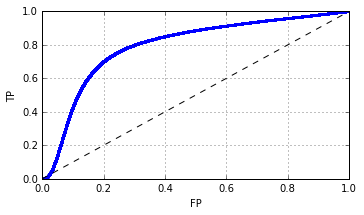

In [9]:
show_result(global_res[0], global_res[1], global_res[2])

#### Alg. 3: Randmized Sketch Update

In [10]:
rand_res = experiment_p(RandomizedSketchUpdate)

Test on 486565 samples:
Avg. detect + update time per timestep = 0.002970 [sec]

precision = 0.658813
recall = 0.649553
F1 = 0.654150
AUC = 0.796320


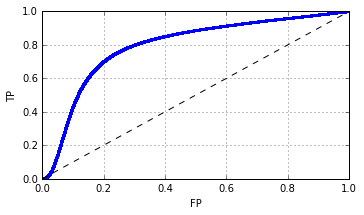

In [11]:
show_result(rand_res[0], rand_res[1], rand_res[2])

#### Alg. 4: Sketch Update

In [12]:
sketch_res = experiment_p(SketchUpdate)

Test on 486565 samples:
Avg. detect + update time per timestep = 0.003734 [sec]

precision = 0.658782
recall = 0.649523
F1 = 0.654120
AUC = 0.796438


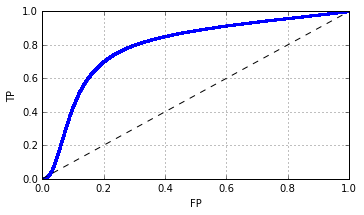

In [13]:
show_result(sketch_res[0], sketch_res[1], sketch_res[2])